In [1]:
import torch as th

from environments.environment_tsp import EnviornmentTSP
from networks.basic_network import BasicNetwork
from params import default_params, set_tsp_params
from experiments.actor_critic_experiment import ActorCriticExperiment
from controllers.ac_controller import ActorCriticController
from learners.reinforce_learner import ReinforceLearner
from generators.tsp_generator import TSPGenerator

In [2]:
# Get params
params = default_params()

# Set TSP params
max_nodes_per_graph = 100
embedding_dimension = 10
max_episodes = 50
params = set_tsp_params(params, max_nodes_per_graph, embedding_dimension, max_episodes)

# Create network
basic_network = BasicNetwork(max_nodes_per_graph = params['max_nodes_per_graph'], 
                            node_dimension = params['node_dimension'], 
                            embedding_dimension = params['embedding_dimension'])

# Create environment
tsp_generator = TSPGenerator()
# cities = th.tensor([[0.0, 0.0], [0.1, 0.1], [0.2, 0.2], [0.3, 0.3], [0.4, 0.4]], dtype=th.float32)
cities = tsp_generator.generate_instance(100)
env = EnviornmentTSP(cities = cities, max_nodes_per_graph = params['max_nodes_per_graph'], node_dimension = params['node_dimension'])

# Create learner 
controller = ActorCriticController(basic_network)
optimizer = th.optim.Adam(basic_network.parameters(), lr=0.001)
learner = ReinforceLearner(model = basic_network, 
                           controller = controller, 
                           optimizer = optimizer, 
                           params = params)

# Create the experiment
experiment = ActorCriticExperiment(params = params, model = basic_network, env = env, learner = learner)


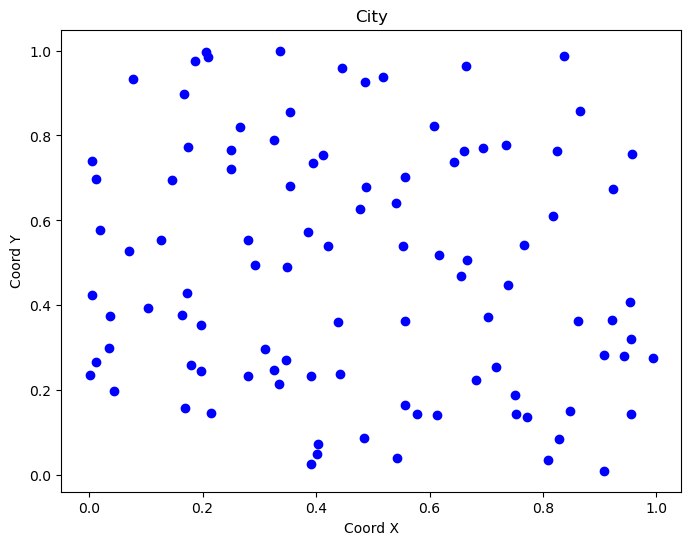

In [3]:
tsp_generator.plot_instance(cities=cities)

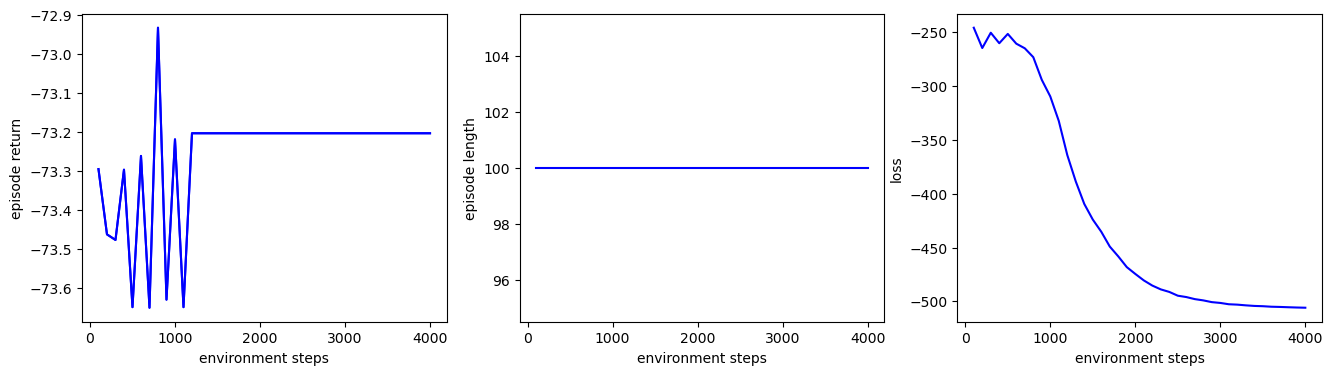

Iteration 40, 100-epi-return -73.26 +- 0.149, length 100, loss -421.471


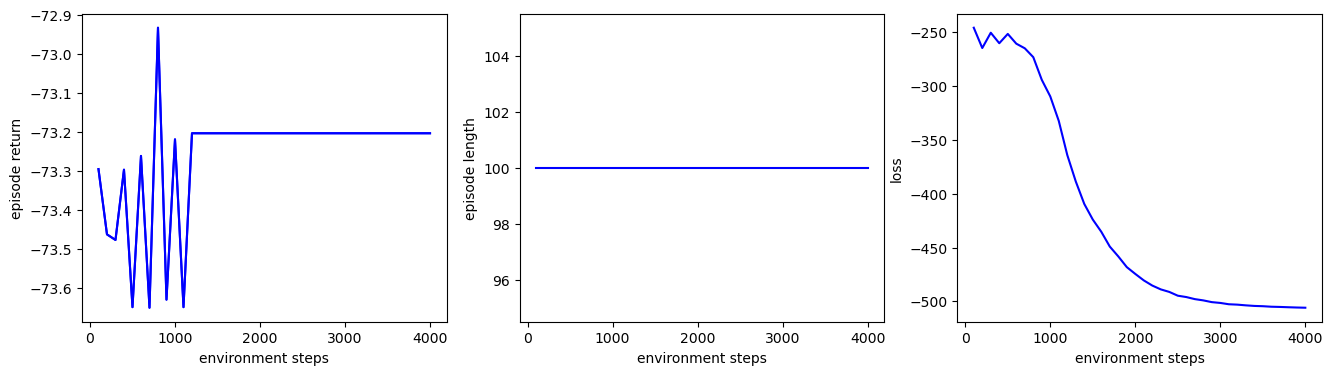

In [4]:
# Run the experiment
experiment.run()

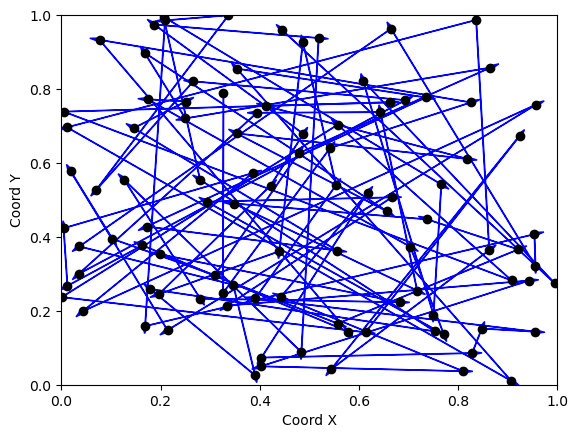

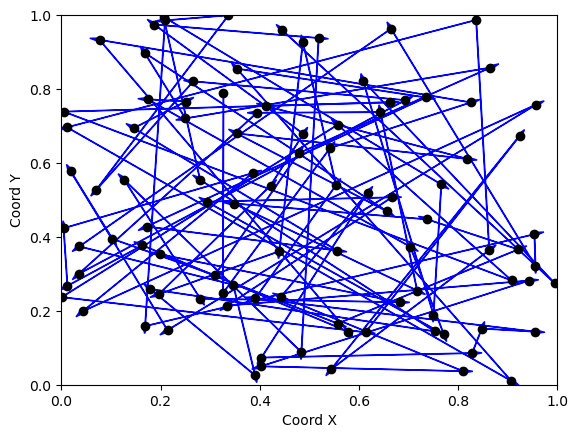

In [5]:
experiment.plot_rollout()